In [2]:
root="C:/github/RatDeconvolution"
path_package="D:/Gdrive/publication/ratdeconv"

## Deconvolution

In [3]:
import sys
import warnings

import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics

sys.path.append(path_package)
from deconv.deconv.deconv import Deconvolution

plt.rcParams["font.size"] = 22
plt.rcParams['font.family'] = 'sans-serif'
warnings.simplefilter('ignore')

In [3]:
def estimate(df_mix, df_ref, number=200, trimming=True, trans="log2",norm=["quantile"]):
    dat = Deconvolution()
    dat.set_data(df_mix, df_ref)
    # use only intersection gene name for creating reference file
    dat.preprocessing_mix(
                        trimming=trimming,batch=False,combat=False,
                        trans_method=trans,
                        norm_method_list=norm)
    # deg extraction
    dat.deg(method="ttest",
            sep="_",number=number,limit_CV=1.,limit_FC=1.,log2=True,q_limit=0.05,
            intersection=trimming,
            plot=True)
    dat.preprocessing_ref(
            trimming=False,batch=False,combat=False,
            trans_method=trans,
            norm_method_list=["quantile"])
    df_ref_processed = dat.get_data()[1]
    # deconvolution
    dat.set_data(df_mix)
    dat.preprocessing_mix(
                        trimming=False,batch=False,combat=False,
                        trans_method=trans,
                        norm_method_list=norm)    
    dat.fit(method="elasticnet")
    df_res = dat.get_res()
    return df_res, df_ref_processed

In [4]:
# load
df_mix = pd.read_csv(f"{root}/data/rnaseq_organ.csv", index_col=0)
df_ref = pd.read_csv(f"{root}/data/rnaseq_reference.csv", index_col=0)
# 
df_mix = df_mix.loc[:,[
    'liverctrl_1', 'liverctrl_2', 'liverctrl_3','liverctrl_4', 'liverctrl_5', 
    'liverapap_1', 'liverapap_2', 'liverapap_3', 'liverapap_4', 'liverapap_5', 
    'livermda_1', 'livermda_2', 'livermda_3', 'livermda_4', 'livermda_5',
    'spleen_1', 'spleen_2', 'spleen_3', 'spleen_4', 'spleen_5',
    'wbc_1', 'wbc_2', 'wbc_3', 'wbc_4', 'wbc_5'
    ]]

df_ref = df_ref.loc[:,[
    'B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 
    'CD4T_1', 'CD4T_2', 'CD4T_3', 'CD4T_4', 'CD4T_5', 'CD4T_6',
    'CD8T_1', 'CD8T_2', 'CD8T_3', 'CD8T_4', 'CD8T_5', 'CD8T_6', 
    'NK_1', 'NK_2', 'NK_3', 'NK_4', 'NK_5', 'NK_6',
    'Mon_1', 'Mon_2', 'Mon_3', 'Mon_4', 'Mon_5', 
    'Mon_6', 'Neu_1', 'Neu_2', 'Neu_3', 'Neu_4', 'Neu_5', 'Neu_6', 
]]

In [5]:
df_mix.head()

,liverctrl_1,liverctrl_2,liverctrl_3,liverctrl_4,liverctrl_5,liverapap_1,liverapap_2,liverapap_3,liverapap_4,liverapap_5,...,spleen_1,spleen_2,spleen_3,spleen_4,spleen_5,wbc_1,wbc_2,wbc_3,wbc_4,wbc_5
A1bg,62.602525,11.842645,9.339545,10.124606,6.886810,2.214081,2.088714,2.567648,2.496724,5.629886,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1cf,265.026900,397.154186,357.365992,433.101659,516.388457,795.131146,497.756515,774.675596,622.711242,904.092086,...,0.472280,0.240038,0.000000,0.229279,0.000000,0.426205,0.000000,1.006054,0.707022,0.450238
A2m,8.677715,15.035406,31.725276,26.209591,38.033613,216.128497,716.198245,335.906524,73.407235,229.560748,...,0.930286,0.682448,1.347626,1.707796,0.337533,0.317244,0.335992,0.122747,0.116148,0.000000
A2ml1,2.294839,3.916314,2.475181,5.630646,7.675757,10.458820,11.655032,3.667897,4.348832,4.490715,...,1.180252,0.954496,2.267479,2.304677,1.822427,1.707593,2.042334,0.747680,2.119078,0.686516
A3galt2,6.569249,2.420075,6.284614,6.418928,3.330428,18.859042,28.778916,14.766489,24.243595,17.302812,...,61.003064,62.727863,35.421425,69.030752,55.094715,9.543369,13.382901,22.338715,15.804415,25.070794


In [6]:
df_ref.head()

,B_1,B_2,B_3,B_4,B_5,B_6,CD4T_1,CD4T_2,CD4T_3,CD4T_4,...,Mon_3,Mon_4,Mon_5,Mon_6,Neu_1,Neu_2,Neu_3,Neu_4,Neu_5,Neu_6
A1bg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1cf,0.000000,0.000000,0.000000,0.450573,0.680732,0.222578,0.000000,0.000000,0.236026,0.000000,...,2.534984,4.211474,2.776478,4.799037,0.000000,0.000000,0.269162,0.275315,0.000000,0.796946
A2m,1.803490,1.903801,0.438613,0.633181,0.427111,1.902186,0.120489,0.124396,0.460510,0.863568,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.112920,0.405404,0.000000,0.000000,0.132392
A2ml1,2.449915,0.998397,0.889402,1.334614,1.350081,2.221031,0.729231,2.505788,1.870450,2.717980,...,1.694357,0.281057,1.387533,0.280780,0.469662,0.000000,0.544773,0.000000,0.000000,0.267065
A3galt2,27.182292,47.004402,23.164272,24.889068,18.847441,23.757346,12.224980,21.623977,18.966017,28.320194,...,66.553977,40.276020,46.097626,53.175529,11.302623,12.624382,12.038670,8.940529,2.319168,26.718475


method : ttest
extracted genes number = 2169
extracted genes number = 4918
extracted genes number = 4320
not enough genes picked up
extracted genes number = 2522
extracted genes number = 6042
extracted genes number = 4838
signature genes : 974


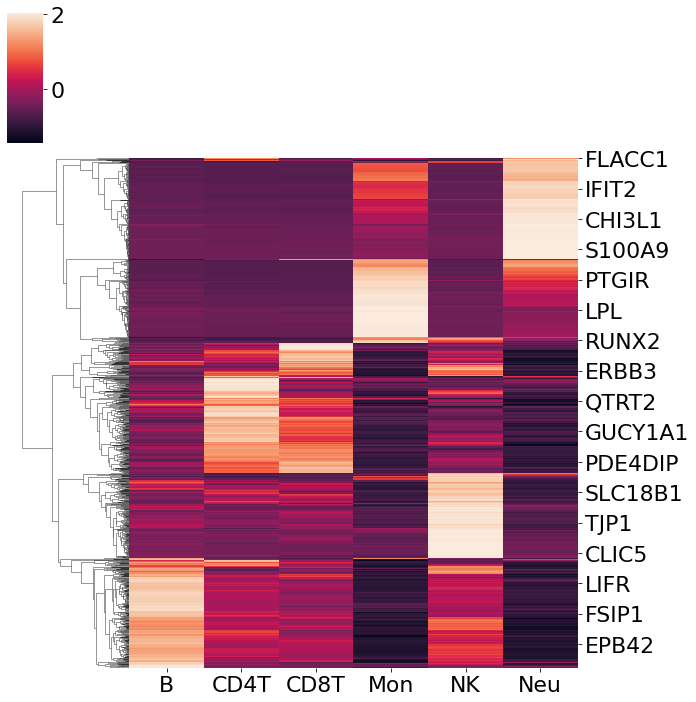

method:  elasticnet


In [7]:
df_res, df_ref_processed = estimate(df_mix, df_ref, number=200, trimming=True, trans="log2",norm=["quantile"])

In [8]:
df_res.head()

,B,CD4T,CD8T,Mon,NK,Neu
liverctrl_1,0.106764,-0.052514,-0.024063,0.054324,0.015656,0.014367
liverctrl_2,0.069722,-0.031462,-0.016096,0.050815,0.000000,0.000000
liverctrl_3,0.114475,-0.045589,-0.015475,0.029749,0.000000,-0.000000
liverctrl_4,0.090102,-0.037390,-0.022502,0.046129,0.000000,0.000000
liverctrl_5,0.091081,-0.014362,-0.023526,0.049834,0.000000,-0.000000


In [9]:
df_ref_processed.head()

,B,CD4T,CD8T,Mon,NK,Neu
SIX5,4.096006,3.894446,3.498057,2.210995,4.466665,2.285055
TBC1D16,5.713616,7.246275,7.705650,4.901688,5.562891,4.798256
GPAM,5.179840,4.102357,3.920407,3.673633,4.559971,2.302658
RGD1307182,4.902704,4.932989,4.820741,6.185461,4.306206,8.184583
ADAM15,4.295533,3.856372,3.860827,7.177072,4.320766,6.962278


In [10]:
df_res.to_csv(f"{root}/result/rnaseq_result.csv")

## Evaluation

In [4]:
def calc_z_pop(res):
    ss = StandardScaler()
    ss.fit(res)
    res_z = pd.DataFrame(ss.transform(res), index=res.index, columns=res.columns).fillna(0)
    return res_z

def calc_z(res, ctrl=""):
    res_ctrl = res.loc[res.index.str.contains(ctrl),:]
    res_drug = res.loc[:,:]
    mean = np.mean(res_ctrl.values,axis=0)
    std = np.std(res_ctrl.values,axis=0)
    res_z = pd.DataFrame((res_drug.values - mean)/std)
    res_z.index = res_drug.index
    res_z.columns = res_drug.columns
    res_z = res_z.replace(np.inf,0)
    res_z = res_z.replace(-np.inf,0)
    res_z = res_z.fillna(0)
    return res_z

def calc_stat(arr, median=True):
    v_median = np.nanmedian(arr)
    v_mean = np.nanmean(arr)
    v_var = st.tvar(arr)
    a, b = st.norm.interval(alpha=0.95, loc=v_mean, scale=np.sqrt(v_var/len(arr)))
    if median:
        return v_median, b-v_mean
    else:
        return v_mean, b-v_mean

def calc_stat_all(x, y):
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    r2 = model.score(x, y)
    r = np.corrcoef(x.reshape(1,-1),y.reshape(1,-1))[0][1]
    spr = st.spearmanr(x,y)[0]
    mae = metrics.mean_absolute_error(y, y_pred)
    rmse = np.sqrt(metrics.mean_absolute_error(y, y_pred))
    return r2, r, spr, mae, rmse

In [5]:
def load(liver=False, zpop=False, raw=False):
    if liver:
        names = [
            'liverctrl_1', 'liverctrl_2', 'liverctrl_3','liverctrl_4', 'liverctrl_5', 
            'liverapap_1', 'liverapap_2', 'liverapap_3', 'liverapap_4', 'liverapap_5', 
            'livermda_1', 'livermda_2', 'livermda_3', 'livermda_4', 'livermda_5',
        ]
    else:
        names = [
            'spleen_1', 'spleen_2', 'spleen_3', 'spleen_4', 'spleen_5',
            'wbc_1', 'wbc_2', 'wbc_3', 'wbc_4', 'wbc_5'
        ]
    df_res = pd.read_csv(f"{root}/result/rnaseq_result.csv",index_col=0)
    df_facs = pd.read_csv(f"{root}/data/rnaseq_count.csv",index_col=0)
    df_res2 = df_res.astype(float)
    df_facs = df_facs.astype(float)
    df_facs.index = [f"{i.split('_')[0]}_{i.split('_')[1]}" if not 'liver' in i else f"{i.split('_')[0]}{i.split('_')[1]}_{i.split('_')[2]}" for i in df_facs.index]
    df_res2 = df_res2.loc[names,:]
    df_facs = df_facs.loc[names,:]
    if raw:
        pass
    else:
        if zpop:
            df_res2 = calc_z_pop(df_res2)
            df_facs = calc_z_pop(df_facs)
        else:
            df_res2 = calc_z(df_res2, ctrl="liverctrl")
            df_facs = calc_z(df_facs, ctrl="liverctrl")
    df_res2.index = [i.split("_")[0] for i in df_res2.index]
    df_facs.index = [i.split("_")[0] for i in df_facs.index]
    return df_res2, df_facs

In [1]:
def plot_fig2a():
    def plot_immune(df1, df2, immunes=[], targets=[], names=[]):
        fig = plt.figure(figsize=(18,8))
        places=[1,2,3,5,6,7]

        for v, immune in enumerate(immunes):
            df_1 = df1.loc[:, immune]
            df_2 = df2.loc[:, immune]
            colors = sns.color_palette(n_colors=len(targets))
            ax = fig.add_subplot(2, 4, places[v])        
            for i, target in enumerate(targets):
                ax.scatter(
                    df_1[target].values, df_2[target].values, 
                    s=70, marker="o", 
                    color="w", label=target,
                    linewidth=4, ec=colors[i],
                    )
            # control lines
            x_min = df_1.min()
            x_max = df_1.max()
            y_min = df_2.min()
            y_max = df_2.max()
            min_all = min(y_min, x_min)
            max_all = max(y_max, x_max)
            ax.plot([min_all, max_all], [min_all, max_all], color='grey', linestyle='dashed')
            ax.hlines(y=0,xmin=min_all,xmax=max_all, color='grey', linestyles='dashed')
            ax.vlines(x=0,ymin=min_all,ymax=max_all, color='grey', linestyles='dashed')
            ax.set_xlabel('Measured')
            ax.set_ylabel('Deconvolution')
            ax.set_title(immune)
            #ax.legend(loc='center left', bbox_to_anchor=(1, 1))
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().yaxis.set_ticks_position('left')
            plt.gca().xaxis.set_ticks_position('bottom')   

        # For Legend
        ax = fig.add_subplot(2,4,8)
        for i, target in enumerate(targets):
            ax.plot([], [], marker="s", color=colors[i], label=names[i], linestyle="none")
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])
        legend = ax.legend(bbox_to_anchor=(.3, 1), loc='upper right',frameon=False, handletextpad=0, ncol=1, columnspacing=1)
        plt.tight_layout()
        #plt.savefig(f"{root}/figures/fig2a.png", dpi=300)
        plt.show()

    df_res2, df_facs = load(liver=False, raw=False, zpop=True)
    plot_immune(df_res2, df_facs, immunes=["Mon", "Neu", "CD4T", "CD8T", "NK", "B"], targets=["spleen", "wbc"], names=["Spleen", "WBC"])

plot_fig2a()

NameError: name 'load' is not defined

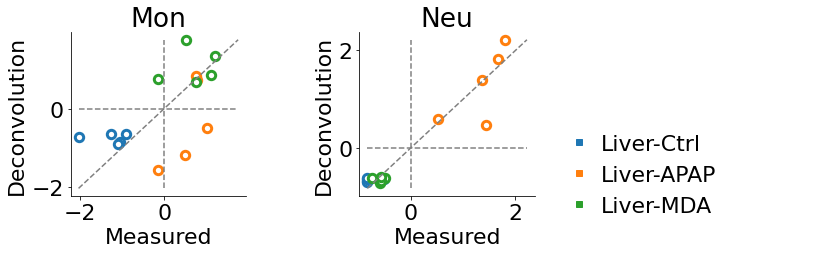

In [10]:
def plot_fig2b():
    def plot_immune(df1, df2, immunes=[], targets=[], names=[]):
        
        fig = plt.figure(figsize=(12,4))
        places=[1,2,3]

        for v, immune in enumerate(immunes):
            df_1 = df1.loc[:, immune]
            df_2 = df2.loc[:, immune]
            colors = sns.color_palette(n_colors=len(targets))
            ax = fig.add_subplot(1, 3, places[v])        
            for i, drug in enumerate(targets):
                ax.scatter(df_1[drug].values, df_2[drug].values, 
                        s=70, marker="o", 
                        color="w", label=drug,
                        linewidth=3, ec=colors[i],
                        )
            # control lines
            x_min = df_1.min()
            x_max = df_1.max()
            y_min = df_2.min()
            y_max = df_2.max()
            min_all = min(y_min, x_min)
            max_all = max(y_max, x_max)
            ax.plot([min_all, max_all], [min_all, max_all], color='grey', linestyle='dashed')
            ax.hlines(y=0,xmin=min_all,xmax=max_all, color='grey', linestyles='dashed')
            ax.vlines(x=0,ymin=min_all,ymax=max_all, color='grey', linestyles='dashed')
            ax.set_xlabel('Measured')
            ax.set_ylabel('Deconvolution')
            ax.set_title(immune)
            #ax.legend(loc='center left', bbox_to_anchor=(1, 1))
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().yaxis.set_ticks_position('left')
            plt.gca().xaxis.set_ticks_position('bottom')   

        # For Legend
        ax = fig.add_subplot(1,3,3)
        for i, drug in enumerate(targets):
            ax.plot([], [], marker="s", color=colors[i], label=names[i], linestyle="none")
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])
        legend = ax.legend(bbox_to_anchor=(.5,.5), loc='upper right',frameon=False, handletextpad=0, ncol=1, columnspacing=1)
        plt.tight_layout()
        #plt.savefig(f"{root}/figures/fig2b.png", dpi=300)
        plt.show()

    df_res2, df_facs = load(liver=True, raw=False, zpop=True)
    plot_immune(df_res2, df_facs, immunes=["Mon", "Neu", ], targets = ["liverctrl", "liverapap", "livermda"], names=["Liver-Ctrl", "Liver-APAP", "Liver-MDA"])

plot_fig2b()